<a href="https://colab.research.google.com/github/atstuyuki/ScikitLearn/blob/main/OP_classification_regretssion_LGBM_JOA_20210912.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline
%config InlineBackend.figure_formate ={'png', 'retina'}

In [ ]:
import os
import sys
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
#ファイルタブからCSVを作業ディレクトリにUpLoad
#CSVファイルをup_load

from google.colab import files
import os
uploaded = files.upload()
#uploadedは辞書型なのでファイル名を取り出し、絶対パスを取得してfullpathという変数を当てる
for k in uploaded.keys():
  print('file name:',k)
fullpath_csv=os.path.abspath(k)
print('fullpath:',fullpath_csv)

Saving angle_data_20220703.csv to angle_data_20220703.csv
file name: angle_data_20220703.csv
fullpath: /content/angle_data_20220703.csv


In [ ]:
df=pd.read_csv(fullpath_csv,sep=',',encoding='UTF-8')#CSVをデータフレームに読み込む
df.head()

,shoulder_angle,elb_shol_hip,shoulder_3D_angle,elb_shol_mid,true_angle
0,97.352868,20.821553,95.144214,7.460141,30
1,99.233216,22.266181,97.390147,8.876193,30
2,118.207911,42.651845,118.072179,29.623566,30
3,119.527660,44.254497,116.666613,31.111930,30
4,119.026206,43.422473,114.181625,30.643535,30


In [ ]:
#dfの型の確認　object型等は変更する必要がある
df.dtypes

shoulder_angle       float64
elb_shol_hip         float64
shoulder_3D_angle    float64
elb_shol_mid         float64
true_angle             int64
dtype: object

In [ ]:
#今回の解析に不要な列をdrop 

df=df.drop(['ID','Height Decrease', 'Body Fat', 'LumberYAM'],axis='columns') 

In [ ]:
#カテゴリ変数をone hot enchoding (drop_first=Trueならダミーエンコーディングなので1次元削減)
#今回はSEX_Mがone hot enchodingされる
df= pd.get_dummies(df,drop_first=True) 
df.dtypes

Age           float64
WBC           float64
Hb            float64
Plt           float64
TP            float64
Alb           float64
AST           float64
ALT           float64
gammaGTP      float64
ALP           float64
Ca            float64
CK            float64
Cl            float64
Na            float64
K             float64
Mg            float64
Cr            float64
BUN           float64
UA            float64
TRACP5b       float64
BAP           float64
P1NP          float64
e-GFR         float64
BMI           float64
femurYAM        int64
Sex_M           uint8
spinalFx_Y      uint8
dtype: object

In [ ]:
# データフレームの統計量記述
#min maxの外れ値をチェックして、外れ値があればもとのCSVデータをチェックしておく
df.describe()

,Age,WBC,Hb,Plt,TP,Alb,AST,ALT,gammaGTP,ALP,Ca,CK,Cl,Na,K,Mg,Cr,BUN,UA,TRACP5b,BAP,P1NP,e-GFR,BMI,femurYAM,Sex_M,spinalFx_Y
count,2783.000000,2763.000000,2763.000000,2762.000000,2763.000000,2762.000000,2763.000000,2763.000000,2762.000000,2597.000000,2761.000000,2761.000000,2763.000000,2763.000000,2763.000000,2761.000000,2763.000000,2762.000000,2761.000000,1786.000000,1856.000000,1788.000000,2760.000000,2738.000000,2795.000000,2795.000000,2795.000000
mean,73.555516,5813.765653,12.987043,22.600072,7.065331,4.262940,23.785306,17.254072,25.577046,224.330813,16.171045,116.670989,105.567871,141.149649,4.671415,3.453604,0.852414,17.868382,5.050493,388.811859,13.768356,50.630766,66.076768,25.224177,75.764222,0.077639,0.433989
std,9.452237,2131.026874,4.822743,7.093263,1.211551,8.274839,33.925102,10.046194,32.260818,90.670717,226.595708,84.154242,27.207251,26.146572,20.474994,46.787613,2.537293,6.047080,8.642050,291.679078,21.062351,54.687466,26.138691,94.282252,12.921901,0.267650,0.495712
min,14.000000,20.800000,7.900000,0.100000,0.800000,2.500000,1.800000,3.000000,7.000000,0.000000,1.980000,2.000000,0.107000,2.090000,0.900000,0.030000,0.170000,0.570000,1.300000,5.700000,2.040000,3.500000,0.000000,0.000000,30.000000,0.000000,0.000000
25%,68.000000,4750.000000,12.000000,18.800000,6.700000,3.900000,18.000000,12.000000,14.000000,166.000000,9.080000,72.000000,103.000000,140.000000,3.900000,1.970000,0.590000,14.025000,3.900000,228.000000,8.600000,22.575000,55.800000,19.280000,68.000000,0.000000,0.000000
50%,74.000000,5610.000000,12.800000,21.900000,7.000000,4.100000,21.000000,15.000000,18.000000,209.000000,9.360000,96.000000,105.000000,141.000000,4.100000,2.080000,0.670000,16.900000,4.700000,341.000000,11.600000,40.800000,65.500000,21.450000,76.000000,0.000000,0.000000
75%,80.000000,6610.000000,13.500000,25.375000,7.300000,4.300000,25.000000,20.000000,26.000000,263.000000,9.650000,135.000000,107.000000,142.000000,4.400000,2.190000,0.780000,20.400000,5.600000,495.000000,15.600000,61.500000,76.125000,23.730000,84.000000,0.000000,1.000000
max,94.000000,65600.000000,131.000000,207.000000,66.000000,435.000000,1718.000000,190.000000,732.000000,1485.000000,8381.000000,1475.000000,1014.000000,1471.000000,1064.600000,2014.000000,76.000000,61.000000,431.000000,6871.000000,606.000000,1200.000000,960.700000,3342.000000,152.000000,1.000000,1.000000


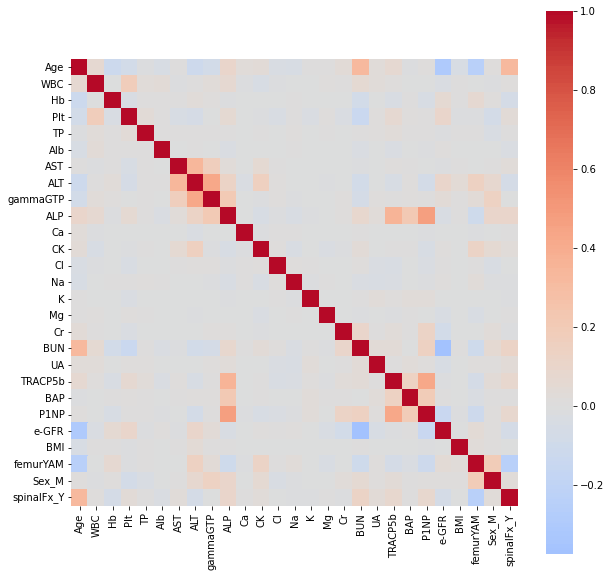

In [ ]:
#dfでの相関係数のheatmap 白黒表示であればcmap='binary'とする
plt.figure(figsize=(10,10))
cmap=sns.color_palette('coolwarm',200)
sns.heatmap(df.corr(),square=True,annot=False,cmap=cmap,center=0)

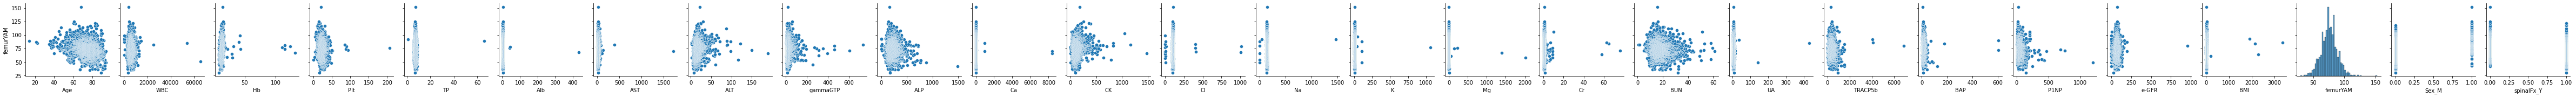

In [ ]:
#dataの可視化　探索的データ解析'EDA'
#pair plot を試す　X軸にすべての項目　ｙ軸に目的変数('femurYAM')を設定
sns.pairplot(df, x_vars=df[0:],y_vars='femurYAM')
plt.show()

In [ ]:
#データセットの分割　正解クラス　説明変数の指定
#訓練データの不要な列を df.drop([],axis='columns')で指定 Lumber YAMは外しておく
train_x=df.drop(['femurYAM'],axis='columns') 
train_y=df['femurYAM']
(train_x,test_x,train_y,test_y)=train_test_split(train_x,train_y,test_size=0.1,random_state=0)

In [ ]:
#データセットの形確認
print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

(2515, 26)
(280, 26)
(2515,)
(280,)


In [ ]:
#train学習データ 教師データ(np.arrayの内容表示）
print(train_x)
print(train_y)

       Age     WBC    Hb   Plt   TP  ...  P1NP  e-GFR    BMI  Sex_M  spinalFx_Y
2587  76.0  3410.0  13.7  21.4  7.5  ...   NaN   67.4  22.65      0           1
1826  88.0  8170.0  14.6  27.1  7.5  ...  31.8   64.6  23.53      0           1
2012  77.0  5210.0  13.6  21.8  6.7  ...  38.4   62.8  27.25      0           0
2134  73.0  6290.0  12.1  19.9  7.1  ...  60.2   67.3  21.63      0           0
1005  80.0  5430.0  13.0  14.3  6.5  ...  11.0   49.3  21.16      0           1
...    ...     ...   ...   ...  ...  ...   ...    ...    ...    ...         ...
763   85.0  6210.0  13.6  29.7  7.9  ...  14.6   83.7  16.13      0           1
835   79.0  4680.0  13.1  18.6  7.3  ...   NaN   64.5  21.11      0           0
1653  69.0  5370.0  12.2  20.8  6.9  ...  71.0   92.8  25.30      0           0
2607  68.0  5540.0  12.7  21.2  6.3  ...  38.9   58.5  22.15      0           0
2732  60.0  4420.0  13.7  22.0  6.7  ...  31.5   76.0  19.48      0           0

[2515 rows x 26 columns]
2587     94
18

In [ ]:
#LightGBMの学習
# train data からさらにvalidation dataを分ける
trn_x,val_x, trn_y, val_y = train_test_split(train_x, train_y,test_size=0.2, random_state=0 )
lgb_dataset_trn=lgb.Dataset(trn_x, label=trn_y, categorical_feature='auto')
lgb_dataset_val=lgb.Dataset(val_x, label= val_y, categorical_feature='auto')

params={
    'objective':'rmse',#‘metric’は、’mean_absolute_error’, ‘mean_squared_error’, ‘rmse’から選ぶ
    'larning_rate':0.1,
    'max_depth':5,
}

lgb_model=lgb.train(
    params=params,
    train_set=lgb_dataset_trn,
    valid_sets=[lgb_dataset_val],
    num_boost_round=1000,
    early_stopping_rounds=100,
    verbose_eval=100

)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 9.16499
[200]	valid_0's rmse: 9.06102
[300]	valid_0's rmse: 9.01304
Early stopping, best iteration is:
[251]	valid_0's rmse: 8.98158


In [ ]:
#RMSEではなくMean absolute percentage error(MAPE)を計算する関数の作成
#MAPE=平均絶対パーセント誤差
def calc_mape(y_true, y_pred):
  data_num = len(y_true)
  mape= (np.sum(np.abs(y_pred-y_true)/y_true)/data_num)*100
  return mape

train_pred =lgb_model.predict(train_x)
train_mape =calc_mape(train_y.values, train_pred)

val_pred = lgb_model.predict(val_x)
val_mape = calc_mape(val_y.values, val_pred)

print(f'train mape: {train_mape:.3f}%')
print(f'valid mape:{val_mape: .3f}%')

train mape: 4.982%
valid mape: 9.668%


In [ ]:
#テストデータに対する評価
test_pred = lgb_model.predict(test_x)
test_mape = calc_mape(test_y.values,test_pred)

print(f'test mape:{test_mape:.3f}%')

test mape:9.429%


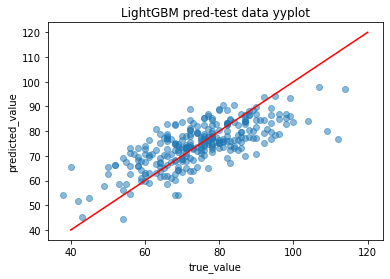

r2:0.527
相関係数:0.726


In [ ]:
#x軸に実際の値　ｙ軸に予測値　YAM 40-120の範囲でプロット
#完全に一致なら赤線の上に点が収まるはず
import matplotlib.pyplot as plt
import numpy as np
plt.scatter(test_y, test_pred, alpha = 0.5)
plt.plot(np.linspace(40, 120, 120), np.linspace(40, 120, 120), "red")
plt.xlabel('true_value')
plt.ylabel('predicted_value')
plt.title('LightGBM pred-test data yyplot')
plt.show()

#決定係数（R^2）の計算
from sklearn.metrics import r2_score
r2= r2_score(test_y,test_pred)
print(f'r2:{r2:.3f}')
#相関係数の計算(決定係数の平方根)
cor=np.sqrt(r2)
print(f'相関係数:{cor:.3f}')

In [ ]:
#optunaのlightGBM用のAPIによるハイパーパラメーターチューニング
#まず ！pipでインストール
!pip install optuna

In [ ]:
import optuna.integration.lightgbm as lgbo
# 回帰の場合
opt_params = {
    "objective":"regression",
    "metric":"rmse"
}
#探索用にデータを作り直す
reg_train = lgb.Dataset(train_x,train_y,free_raw_data=False)
reg_eval = lgb.Dataset(test_x,test_y,free_raw_data=False)

#パラメータを探す
opt=lgbo.train(
    opt_params,
    reg_train,
    valid_sets = reg_eval,
    verbose_eval=False,
    #ラウンド数
    num_boost_round = 5,
    #打ち切り
    #early_stopping_rounds = 100
)

[I 2021-09-20 01:46:59,342] A new study created in memory with name: no-name-c1bf6d3b-2612-4aa6-9c7d-b575eab6491e
min_data_in_leaf, val_score: 10.448401: 100%|##########| 5/5 [00:00<00:00,  8.26it/s]


In [ ]:
#最適なパラメータを取得 optunaでのベストモデルがoptになっている
opt.params

{'bagging_fraction': 1.0,
 'bagging_freq': 0,
 'feature_fraction': 1.0,
 'feature_pre_filter': False,
 'lambda_l1': 0.0,
 'lambda_l2': 0.0,
 'metric': 'rmse',
 'min_child_samples': 5,
 'num_leaves': 232,
 'objective': 'regression'}

In [ ]:
# 選んだパラメータで再度学習
opt_model = lgb.train(params=opt.params,
    train_set=reg_train,
    valid_sets=reg_eval,
    num_boost_round=1000,
    early_stopping_rounds=100,
    verbose_eval=100,)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 8.29588
[200]	valid_0's rmse: 8.29388
Early stopping, best iteration is:
[119]	valid_0's rmse: 8.29099


In [ ]:
#テストデータで予測して、予測値を算出
op_test_pred = opt_model.predict(test_x)
op_test_mape = calc_mape(test_y.values,op_test_pred)

print(f'Oputuna test mape:{op_test_mape:.3f}%')

Oputuna test mape:8.747%


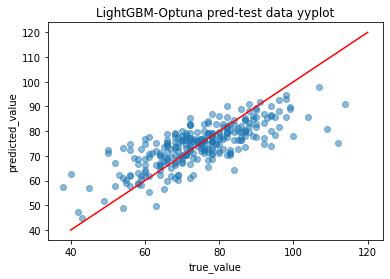

Oputuna test r2:0.571
Oputuna 相関係数:0.756


In [ ]:
#x軸に実際の値　ｙ軸に予測値　YAM 40-120の範囲でプロット
#完全に一致なら赤線の上に点が収まるはず
import matplotlib.pyplot as plt
import numpy as np
plt.scatter(test_y, op_test_pred, alpha = 0.5)
plt.plot(np.linspace(40, 120, 120), np.linspace(40, 120, 120), "red")
plt.xlabel('true_value')
plt.ylabel('predicted_value')
plt.title('LightGBM-Optuna pred-test data yyplot')
plt.show()

#決定係数（R^2）の計算
from sklearn.metrics import r2_score
op_r2= r2_score(test_y,op_test_pred)
print(f'Oputuna test r2:{op_r2:.3f}')
#相関係数の計算
op_cor = np.sqrt(op_r2)
print(f'Oputuna 相関係数:{op_cor:.3f}')

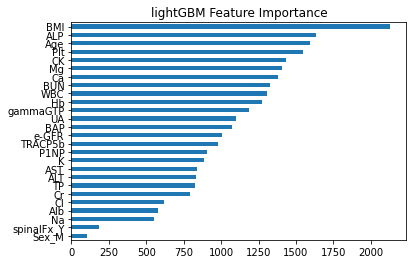

In [ ]:
# feature importanceの可視化1
feat_imp = pd.Series(opt_model.feature_importance(), index=test_x.columns).sort_values(ascending=False)
feat_imp = feat_imp.head(30)
feat_imp = feat_imp.sort_values(ascending=True)
feat_imp.plot(kind='barh', title='lightGBM Feature Importance', color=sns.color_palette()[0])
plt.show()

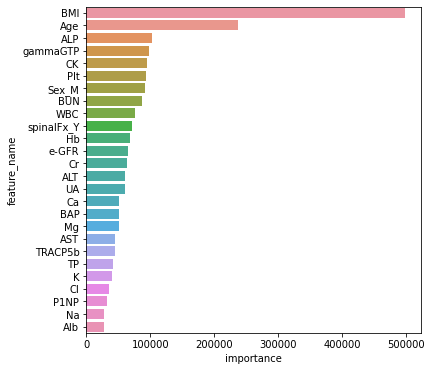

In [ ]:
#feature importanceの可視化2
feature_importance = pd.DataFrame({
    'feature_name': opt_model.feature_name(),
    'importance': opt_model.feature_importance(importance_type='gain'),
})
feature_importance = feature_importance.sort_values('importance', ascending = False)

plt.figure(figsize= (6,6))
sns.barplot(data = feature_importance, x ='importance', y='feature_name')
plt.savefig('feature_importance.png')

In [ ]:
!pip install shap #shapをインストール

     |████████████████████████████████| 356 kB 4.2 MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491649 sha256=ee1c1ef36c76e9354eb5680cea08b20afb71eac55327cfbd21fd78c2dc010d3e
  Stored in directory: /root/.cache/pip/wheels/ca/25/8f/6ae5df62c32651cd719e972e738a8aaa4a87414c4d2b14c9c0
Successfully built shap


In [ ]:
#shapをインポートしてモデルのshap値を計算
import shap
lgb_explainer = shap.TreeExplainer(opt_model, train_x)
lgb_shap_values = lgb_explainer.shap_values(train_x)


 99%|===================| 2498/2515 [01:23<00:00]       

In [ ]:
# jupyter notebookにコードを表示させるためにjsをロード
shap.initjs()

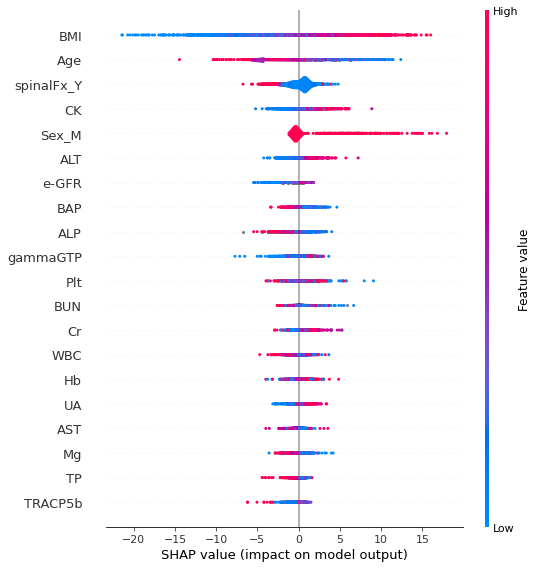

In [ ]:
# LightGBMでのViolin Plotの可視化
shap.summary_plot(lgb_shap_values, train_x, plot_type="violin")#ploty type 'dot' or 'violin'

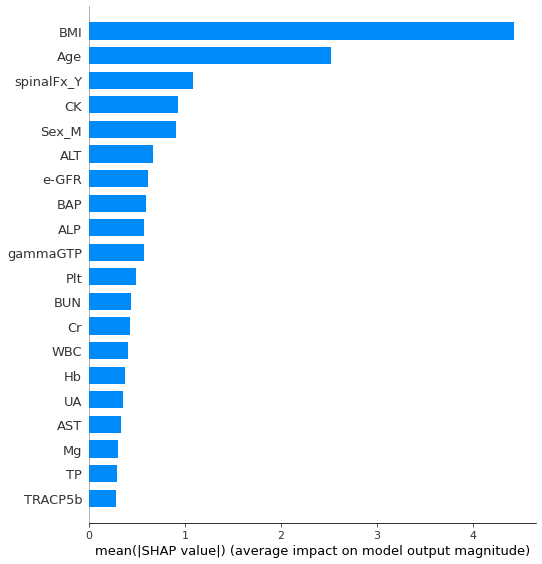

In [ ]:
shap.summary_plot(lgb_shap_values, train_x, plot_type="bar")

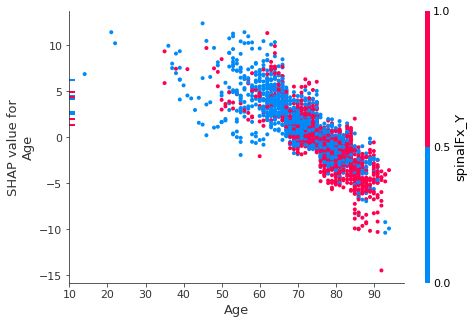

In [ ]:
# LightGBMでのPartial Dependence Plotの可視化
#shap.dependence_plot("rank(1)",interaction_index='BMI',lgb_shap_values, train_x)
shap.dependence_plot(ind='Age',
                     interaction_index='spinalFx_Y',
                     shap_values=lgb_shap_values,
                     features=train_x,
                     feature_names=train_x.columns)

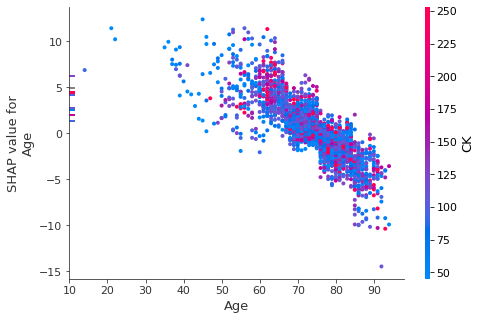

In [ ]:
# LightGBMでのPartial Dependence Plotの可視化
shap.dependence_plot(ind='Age',
                     interaction_index='CK',
                     shap_values=lgb_shap_values,
                     features=train_x,
                     feature_names=train_x.columns)

In [ ]:
#Force plotによる可視化
#google colabでは動かなかった　ローカルなら動くかも
'''shap.force_plot(base_value=lgb_explainer.expected_value,
                shap_values=lgb_shap_values,
                features=train_x,
                feature_names=train_x.columns)'''

NameError: ignored

In [ ]:
#参考サイト　https://takaherox.hatenablog.com/entry/2020/07/06/234337
import numpy as np
import pandas as pd
import xgboost as xgb
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import classification_report

In [ ]:
# 固定パラメータの指定
SEED = 42
TEST_SIZE = 0.2
target = "class"
predictors = [i for i in df.columns if i not in target]

In [ ]:
## XGBoostモデル作成
params = {
    "objective" : "reg:squarederror",
    "eval_metric" : "rmse"
}

 # モデルの学習
xgb_train = xgb.DMatrix(train_x,train_y)
xgb_test = xgb.DMatrix(test_x, test_y)
evals_result = {}
xgb_model = xgb.train(
    params,
    xgb_train,
    num_boost_round=5000,  
    early_stopping_rounds=500,
    evals = [(xgb_test, 'eval'), (xgb_train, 'train')],
    evals_result=evals_result,
     verbose_eval=100
    
)             

[0]	eval-rmse:53.0575	train-rmse:54.1814
Multiple eval metrics have been passed: 'train-rmse' will be used for early stopping.

Will train until train-rmse hasn't improved in 500 rounds.
[100]	eval-rmse:8.5236	train-rmse:1.51153
[200]	eval-rmse:8.62657	train-rmse:0.279024
[300]	eval-rmse:8.62761	train-rmse:0.049364
[400]	eval-rmse:8.62815	train-rmse:0.01085
[500]	eval-rmse:8.62754	train-rmse:0.002204
[600]	eval-rmse:8.62745	train-rmse:0.001275
[700]	eval-rmse:8.62745	train-rmse:0.001275
[800]	eval-rmse:8.62745	train-rmse:0.001275
[900]	eval-rmse:8.62745	train-rmse:0.001275
[1000]	eval-rmse:8.62745	train-rmse:0.001275
Stopping. Best iteration:
[541]	eval-rmse:8.62745	train-rmse:0.001275



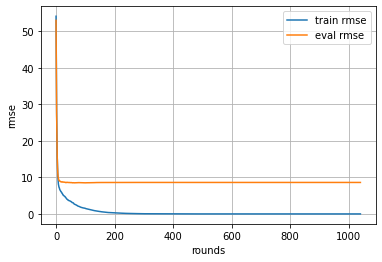

In [ ]:
#trainデータに対してのloss推移をplot
plt.plot(evals_result['train']['rmse'], label='train rmse')
#testデータに対してのloss推移をplot
plt.plot(evals_result['eval']['rmse'], label='eval rmse')
plt.grid()
plt.legend()
plt.xlabel('rounds')
plt.ylabel('rmse')
plt.savefig("img.png", bbox_inches='tight')
plt.show()

In [ ]:
pred = xgb_model.predict(xgb_test)
print(pred)

[ 77.827866  66.38928   59.102993  62.61696   75.74644   71.748245
  77.34448   58.845016  70.92256   81.58963   77.17638   64.054375
  68.72776   79.03468   80.77228   85.69619   55.65187   74.57256
  91.44058   74.46366   77.64446   86.05612   83.51025   82.61265
  64.307076  74.293365  70.45937   70.61402   65.136     76.001526
  80.58286   73.7065    66.4993    58.11356   71.87041   71.17335
  80.4107    93.70577   68.31032   60.896236  75.10045   76.262794
  76.82518   63.67913   64.755844  78.54079   82.98923   49.51609
  81.60208   70.470024  54.9044    58.79631   86.492744  59.415188
  79.52026   69.601395  79.72389   81.04077   53.75171   79.91275
  90.2458    96.92885   69.00629   86.394554  77.51318   73.69072
  64.365425  81.127045  83.63729   78.999916  92.99102   67.35815
  72.51743   84.859474  88.458     67.64543   41.674282  64.61788
  76.09299   64.05984   72.06537   78.22824   77.354935  55.974415
  85.38545   80.56062   70.84167   65.44161   81.91563   85.27889
  74

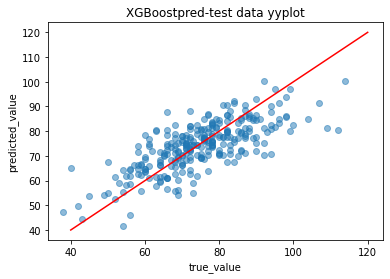

r2:0.535
相関係数:0.732
rmse:8.627


In [ ]:
#実測値と予測値のyyplot
plt.scatter(test_y, pred, alpha = 0.5)
plt.plot(np.linspace(40, 120, 120), np.linspace(40, 120, 120), "red")
plt.xlabel('true_value')
plt.ylabel('predicted_value')
plt.title('XGBoostpred-test data yyplot')
plt.show()

#決定係数（R^2）の計算
from sklearn.metrics import r2_score
r2= r2_score(test_y,pred)
print(f'r2:{r2:.3f}')
#相関係数の計算(決定係数の平方根)
cor=np.sqrt(r2)
print(f'相関係数:{cor:.3f}')
#rmseの計算
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(test_y, pred)
rmse = np.sqrt(mse)
print(f'rmse:{rmse:.3f}')

In [ ]:
#optunaによるXGBoostのハイパーパラメーターチューニング
#参考文献の都合でscikitlearnAPI使用
f#rom xgboost import XGBRegressor

In [ ]:
# optunaの目的関数を設定する
#gtreeのパラメーター設定です。
'''def objective(trial):
    eta =  trial.suggest_loguniform('eta', 1e-8, 1.0)
    gamma = trial.suggest_loguniform('gamma', 1e-8, 1.0)
    max_depth = trial.suggest_int('max_depth', 1, 20)
    min_child_weight = trial.suggest_loguniform('min_child_weight', 1e-8, 1.0)
    max_delta_step = trial.suggest_loguniform('max_delta_step', 1e-8, 1.0)
    subsample = trial.suggest_uniform('subsample', 0.0, 1.0)
    reg_lambda = trial.suggest_uniform('reg_lambda', 0.0, 1000.0)
    reg_alpha = trial.suggest_uniform('reg_alpha', 0.0, 1000.0)


    regr =xgb.XGBRegressor(eta = eta, gamma = gamma, max_depth = max_depth,
                           min_child_weight = min_child_weight, max_delta_step = max_delta_step,
                           subsample = subsample,reg_lambda = reg_lambda,reg_alpha = reg_alpha)

    score = cross_val_score(regr, train_x, train_y, cv=5, scoring="r2")
    r2_mean = score.mean()
    print(r2_mean)

    return r2_mean'''

def objective(trial):

    params = {
        "silent": 1,
        "max_depth": trial.suggest_int("max_depth", 6, 9),
        "min_child_weight": 1,
        "eta": trial.suggest_loguniform("eta", 0.01, 1.0),
        "tree_method": "exact",
        "objective": "reg:linear",
        "eval_metric": "rmse",
        "predictor": "cpu_predictor"  
    }

    cv_results = xgb.cv(
        params,
        xgb_train,
        num_boost_round=1000,
        seed=0,
        nfold=5, # CVの分割数
        metrics={"rmse"},
        early_stopping_rounds=5
    )

    return cv_results["test-rmse-mean"].min()

In [ ]:
# optunaで最適値を見つける
import optuna
from sklearn.model_selection import cross_val_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=500)



[I 2021-09-20 04:04:37,967] A new study created in memory with name: no-name-946001fd-7b2d-424c-bbce-7a4e903aadae
[I 2021-09-20 04:04:44,219] Trial 0 finished with value: 9.490362600000001 and parameters: {'max_depth': 7, 'eta': 0.1953073280434062}. Best is trial 0 with value: 9.490362600000001.
[I 2021-09-20 04:04:44,748] Trial 1 finished with value: 11.2750886 and parameters: {'max_depth': 8, 'eta': 0.9365295064616197}. Best is trial 0 with value: 9.490362600000001.
[I 2021-09-20 04:05:03,287] Trial 2 finished with value: 9.278573999999999 and parameters: {'max_depth': 6, 'eta': 0.024116651116789442}. Best is trial 2 with value: 9.278573999999999.
[I 2021-09-20 04:05:05,965] Trial 3 finished with value: 9.802630400000002 and parameters: {'max_depth': 8, 'eta': 0.30592228539929645}. Best is trial 2 with value: 9.278573999999999.
[I 2021-09-20 04:05:08,797] Trial 4 finished with value: 9.5692464 and parameters: {'max_depth': 6, 'eta': 0.18790269429483447}. Best is trial 2 with value: 9

In [ ]:
# チューニングしたハイパーパラメーターをフィット モデル名をop_xgbとする
op_xgb = xgb.XGBRegressor(eta = study.best_params['eta'],gamma = study.best_params['gamma'],
                                max_depth = study.best_params['max_depth'],min_child_weight = study.best_params['min_child_weight'],
                                max_delta_step = study.best_params['max_delta_step'],subsample = study.best_params['subsample'],
                                reg_lambda = study.best_params['reg_lambda'],reg_alpha = study.best_params['reg_alpha'])

op_xgb.fit(train_x,train_y)

[03:29:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eta=3.0680317930809418e-06,
             gamma=2.419998499480105e-06, importance_type='gain',
             learning_rate=0.1, max_delta_step=0.9994509934000394, max_depth=2,
             min_child_weight=8.64729758771864e-06, missing=None,
             n_estimators=100, n_jobs=1, nthread=None, objective='reg:linear',
             random_state=0, reg_alpha=618.3043262599664,
             reg_lambda=178.5450260040626, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.6050738068090181, verbosity=1)

In [ ]:
#optunaによる最適化モデル(op_xgb)による予測
y_train_pred = op_xgb.predict(train_x)
y_test_pred = op_xgb.predict(test_x)

#評価指標の計算
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

print('MSE   train: %.3f,  test: %.3f' % (
        mean_squared_error(train_y, y_train_pred),
        mean_squared_error(test_y, y_test_pred)))
print('RMSE  train: %.3f,  test: %.3f' %(
        np.sqrt(mean_squared_error(train_y, y_train_pred)),
        np.sqrt(mean_squared_error(test_y, y_test_pred))))
print('R^2   train: %.3f,  test: %.3f' % (
        r2_score(train_y, y_train_pred),
        r2_score(test_y, y_test_pred)))

MSE   train: 4444.821,  test: 4267.440
RMSE  train: 66.669,  test: 65.326
R^2   train: -25.538,  test: -25.636


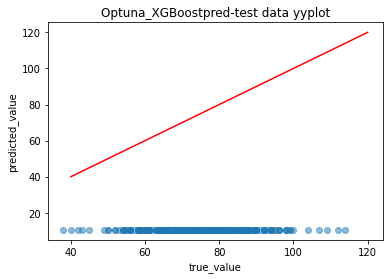

r2:-25.636
相関係数:nan
rmse:65.326


invalid value encountered in sqrt


In [ ]:
#実測値と予測値のyyplot
plt.scatter(test_y, y_test_pred, alpha = 0.5)
plt.plot(np.linspace(40, 120, 120), np.linspace(40, 120, 120), "red")
plt.xlabel('true_value')
plt.ylabel('predicted_value')
plt.title('Optuna_XGBoostpred-test data yyplot')
plt.show()

#決定係数（R^2）の計算
from sklearn.metrics import r2_score
r2= r2_score(test_y,y_test_pred)
print(f'r2:{r2:.3f}')
#相関係数の計算(決定係数の平方根)
cor=np.sqrt(r2)
print(f'相関係数:{cor:.3f}')
#rmseの計算
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(test_y, y_test_pred)
rmse = np.sqrt(mse)
print(f'rmse:{rmse:.3f}')

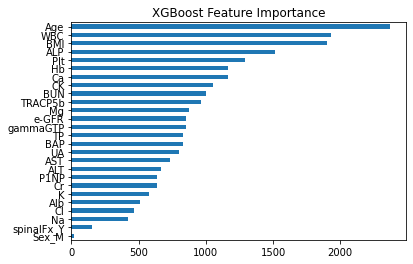

In [ ]:
# feature importanceの可視化

feat_imp = pd.Series(xgb_model.get_fscore()).sort_values(ascending=False)
feat_imp = feat_imp.head(30)
feat_imp = feat_imp.sort_values(ascending=True)
feat_imp.plot(kind='barh', title='XGBoost Feature Importance', color=sns.color_palette()[0])
plt.show()

In [ ]:
'''#Xgboost scikit learn APIによるgrid search 
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error

xgb_reg = xgb.XGBRegressor()

params=[{'max_depth':[3,4,5,6],
        'n_estimators':[100,300,500]
       }]

scorer=make_scorer(mean_squared_error, False)

grid_xgb_reg=GridSearchCV(xgb_reg,
                          param_grid=params,
                          scoring=scorer,
                          cv=5,
                          n_jobs=-1)

grid_xgb_reg.fit(train_x, train_y)

y_train_pred = grid_xgb_reg.predict(train_x)
y_test_pred = grid_xgb_reg.predict(test_x)

# 最良スコアとなるパラメータ値を出力
print(grid_xgb_reg.best_params_)'''

[11:32:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
{'max_depth': 6, 'n_estimators': 500}


In [ ]:
#評価指標の計算
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

print('MSE   train: %.3f,  test: %.3f' % (
        mean_squared_error(train_y, y_train_pred),
        mean_squared_error(test_y, y_test_pred)))
print('RMSE  train: %.3f,  test: %.3f' %(
        np.sqrt(mean_squared_error(train_y, y_train_pred)),
        np.sqrt(mean_squared_error(test_y, y_test_pred))))
print('R^2   train: %.3f,  test: %.3f' % (
        r2_score(train_y, y_train_pred),
        r2_score(test_y, y_test_pred)))

MSE   train: 0.354,  test: 76.086
RMSE  train: 0.595,  test: 8.723
R^2   train: 0.998,  test: 0.525


In [ ]:
#もう一度grid serachを実行
# 調整するハイパーパラメータの値の候補を設定
#この総当たり法は無限に時間がかかる
'''from xgboost import XGBRegressor
test_params = {'n_estimators':[100,200,300,400,500],
               'max_depth':[2,3,4,6,10],
    'min_child_weight':[1,2,3,4,6,10],
    'gamma':[0.0,0.1,0.2,2.0,10.0],
    'subsample':[0.5,0.6,0.7,0.8,0.9,1.0],
    'colsample_bytree':[0.5,0.6,0.7,0.8,0.9,1.0],
    'reg_alpha':[100,1,0,.1,.01,.001,.0001],
    'reg_lambda':[100,1,0,.1,.01,.001,.0001],
    'learning_rate':[.1,.8,0.5,0.3,.01,.001,.0001]
}

# グリッドサーチCVの実行
gridsearch = GridSearchCV(estimator = XGBRegressor( seed=42),
                           param_grid = test_params, scoring='explained_variance',
                           cv = 5, return_train_score=False)

gridsearch.fit(train_x,train_y,n_jobs=-1, verbose=100,)'''

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: fit() got an unexpected keyword argument 'n_jobs'

  FitFailedWarning)


KeyboardInterrupt: ignored

In [ ]:
gridsearch.best_params_
xgb_best= gridsearch.best_estimator_

numpy.ndarray

In [ ]:
# XgboostのSHAP Valueの計算
xgb_explainer = shap.TreeExplainer(xgb_model)#オリジナルAPIもしくはscikit learn API のモデルを渡す
xgb_shap_values = xgb_explainer.shap_values(train_x)


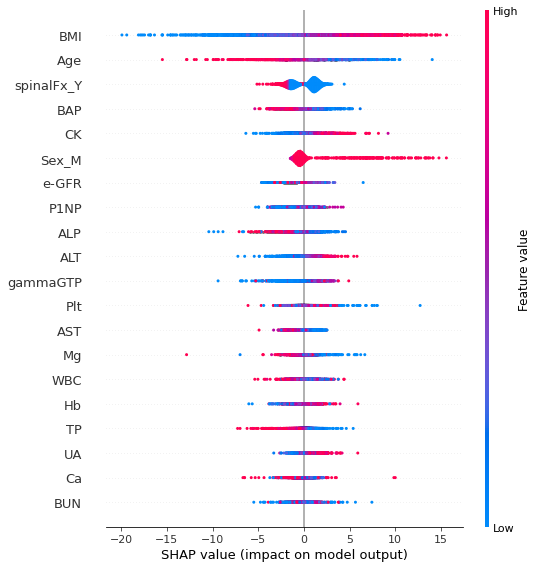

In [ ]:
# XgboostでのViolin Plotの可視化
shap.summary_plot(xgb_shap_values,train_x,plot_type='violin')

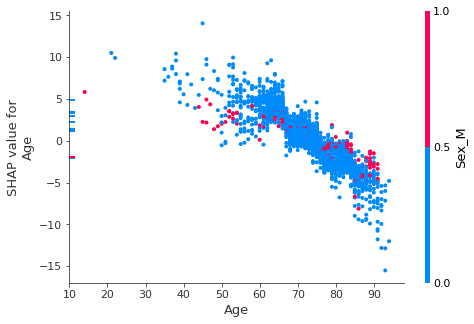

In [ ]:
# XgboostでのPartial Dependence Plotの可視化
shap.dependence_plot("rank(1)", xgb_shap_values, train_x)

In [ ]:
#データフレームを書き換えて2値分類を行う
#再度CSVを読み込んでデータフレームに変換しdf1とする
df1=pd.read_csv("/content/op_databae_20210911_JOA.csv",sep=',',encoding='UTF-8')#CSVをデータフレームに読み込む
df1.head()

,ID,Age,Sex,Height Decrease,Body Fat,WBC,Hb,Plt,TP,Alb,AST,ALT,gammaGTP,ALP,Ca,CK,Cl,Na,K,Mg,Cr,BUN,UA,TRACP5b,BAP,P1NP,e-GFR,spinalFx,BMI,femurYAM,LumberYAM
0,76054647.0,89.0,F,10.1,5.8,3300.0,8.6,16.3,6.9,4.0,19.0,8.0,17.0,173.0,10.12,93.0,102.0,138.0,4.3,3.30,1.50,31.9,7.7,962.0,12.6,143.0,25.4,Y,18.13,30,69.0
1,94040789.0,77.0,F,NaN,NaN,5870.0,12.8,17.8,6.9,4.2,20.0,15.0,28.0,172.0,9.67,86.0,104.0,139.0,4.1,1.80,0.68,19.7,5.8,NaN,NaN,NaN,62.8,Y,21.02,35,80.0
2,10028983.0,67.0,F,-150.0,18.0,7970.0,12.7,26.6,8.1,4.4,24.0,13.0,30.0,NaN,9.38,149.0,95.0,133.0,4.1,2.00,0.83,22.0,4.6,912.0,40.1,93.3,52.6,Y,14.00,36,52.0
3,10028983.0,67.0,F,NaN,NaN,7430.0,12.1,28.1,8.4,4.5,21.0,12.0,23.0,NaN,10.65,142.0,104.0,143.0,3.6,2.24,0.96,19.2,5.0,NaN,NaN,NaN,44.8,Y,14.10,36,56.0
4,95054995.0,86.0,F,16.7,19.2,6030.0,10.2,29.5,7.0,3.0,27.0,25.0,9.0,267.0,8.53,45.0,100.0,139.0,4.3,2.25,0.49,11.9,3.3,475.0,10.1,29.8,87.1,Y,12.36,36,49.0


In [ ]:
#今回の解析に不要な列をdrop 

df1=df1.drop(['ID','Height Decrease', 'Body Fat', 'LumberYAM'],axis='columns') 

In [ ]:
#カテゴリ変数をone hot enchoding (drop_first=Trueならダミーエンコーディングなので1次元削減)
#今回はSEX_Mがone hot enchodingされる
df1= pd.get_dummies(df1,drop_first=True) 
df1.dtypes

Age           float64
WBC           float64
Hb            float64
Plt           float64
TP            float64
Alb           float64
AST           float64
ALT           float64
gammaGTP      float64
ALP           float64
Ca            float64
CK            float64
Cl            float64
Na            float64
K             float64
Mg            float64
Cr            float64
BUN           float64
UA            float64
TRACP5b       float64
BAP           float64
P1NP          float64
e-GFR         float64
BMI           float64
femurYAM        int64
Sex_M           uint8
spinalFx_Y      uint8
dtype: object

In [ ]:
#femurYAM>=70を1に　＜70を0に置き換える
#この順にしないとfemurYAMの値がすべて0になってしまう
df1.loc[df1.femurYAM<70,'femurYAM']=0
df1.loc[df1.femurYAM>=70,'femurYAM']=1
#df1.head()
df1.describe()

,Age,WBC,Hb,Plt,TP,Alb,AST,ALT,gammaGTP,ALP,Ca,CK,Cl,Na,K,Mg,Cr,BUN,UA,TRACP5b,BAP,P1NP,e-GFR,BMI,femurYAM,Sex_M,spinalFx_Y
count,2783.000000,2763.000000,2763.000000,2762.000000,2763.000000,2762.000000,2763.000000,2763.000000,2762.000000,2597.000000,2761.000000,2761.000000,2763.000000,2763.000000,2763.000000,2761.000000,2763.000000,2762.000000,2761.000000,1786.000000,1856.000000,1788.000000,2760.000000,2738.000000,2795.000000,2795.000000,2795.000000
mean,73.555516,5813.765653,12.987043,22.600072,7.065331,4.262940,23.785306,17.254072,25.577046,224.330813,16.171045,116.670989,105.567871,141.149649,4.671415,3.453604,0.852414,17.868382,5.050493,388.811859,13.768356,50.630766,66.076768,25.224177,0.701610,0.077639,0.433989
std,9.452237,2131.026874,4.822743,7.093263,1.211551,8.274839,33.925102,10.046194,32.260818,90.670717,226.595708,84.154242,27.207251,26.146572,20.474994,46.787613,2.537293,6.047080,8.642050,291.679078,21.062351,54.687466,26.138691,94.282252,0.457633,0.267650,0.495712
min,14.000000,20.800000,7.900000,0.100000,0.800000,2.500000,1.800000,3.000000,7.000000,0.000000,1.980000,2.000000,0.107000,2.090000,0.900000,0.030000,0.170000,0.570000,1.300000,5.700000,2.040000,3.500000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,68.000000,4750.000000,12.000000,18.800000,6.700000,3.900000,18.000000,12.000000,14.000000,166.000000,9.080000,72.000000,103.000000,140.000000,3.900000,1.970000,0.590000,14.025000,3.900000,228.000000,8.600000,22.575000,55.800000,19.280000,0.000000,0.000000,0.000000
50%,74.000000,5610.000000,12.800000,21.900000,7.000000,4.100000,21.000000,15.000000,18.000000,209.000000,9.360000,96.000000,105.000000,141.000000,4.100000,2.080000,0.670000,16.900000,4.700000,341.000000,11.600000,40.800000,65.500000,21.450000,1.000000,0.000000,0.000000
75%,80.000000,6610.000000,13.500000,25.375000,7.300000,4.300000,25.000000,20.000000,26.000000,263.000000,9.650000,135.000000,107.000000,142.000000,4.400000,2.190000,0.780000,20.400000,5.600000,495.000000,15.600000,61.500000,76.125000,23.730000,1.000000,0.000000,1.000000
max,94.000000,65600.000000,131.000000,207.000000,66.000000,435.000000,1718.000000,190.000000,732.000000,1485.000000,8381.000000,1475.000000,1014.000000,1471.000000,1064.600000,2014.000000,76.000000,61.000000,431.000000,6871.000000,606.000000,1200.000000,960.700000,3342.000000,1.000000,1.000000,1.000000


In [ ]:
#dfの欠損値の確認
df1.isnull().sum()

Age             12
WBC             32
Hb              32
Plt             33
TP              32
Alb             33
AST             32
ALT             32
gammaGTP        33
ALP            198
Ca              34
CK              34
Cl              32
Na              32
K               32
Mg              34
Cr              32
BUN             33
UA              34
TRACP5b       1009
BAP            939
P1NP          1007
e-GFR           35
BMI             57
femurYAM         0
Sex_M            0
spinalFx_Y       0
dtype: int64

In [ ]:
#Pandasで目的変数別に色分けしたヒストグラムを作成する
#関数の指定
#http://own-search-and-study.xyz/2018/02/27/pandas%e3%81%a7%e7%9b%ae%e7%9a%84%e5%a4%89%e6%95%b0%e5%88%a5%e3%81%ab%e8%89%b2%e5%88%86%e3%81%91%e3%81%97%e3%81%9f%e3%83%92%e3%82%b9%e3%83%88%e3%82%b0%e3%83%a9%e3%83%a0%e3%82%92%e4%bd%9c%e6%88%90/
import pandas as pd
 
def targethist(df, target, save=False, kind='hist', **kwards):
     
    columns = df.columns[df.columns != target]
    pdf = df.pivot_table(index=df.index, columns=target)
     
    for column in columns:
         
        ax = pdf.loc[:, column].plot(kind=kind, title=column, **kwards)
         
        if save==True:
            ax.get_figure().savefig(column+".png") 

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


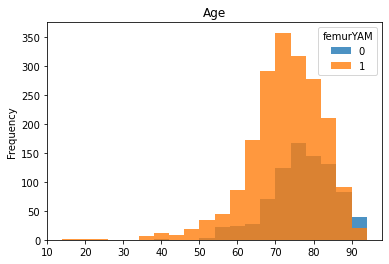

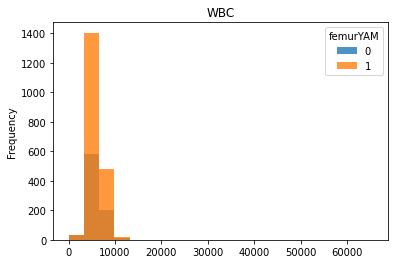

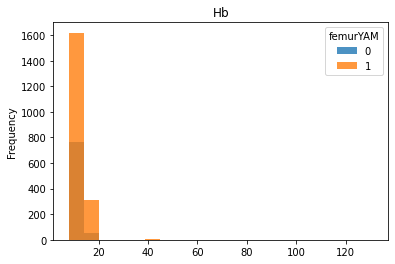

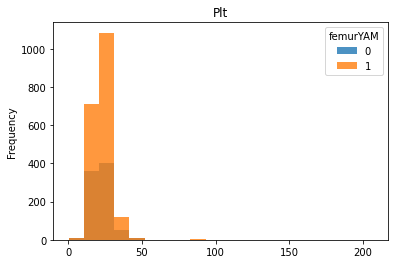

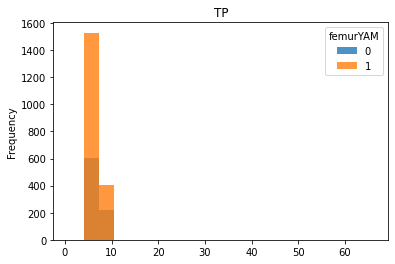

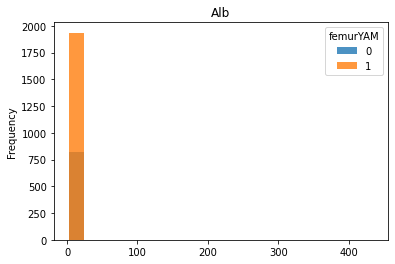

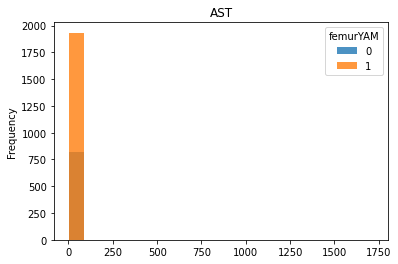

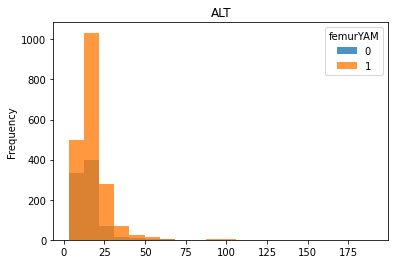

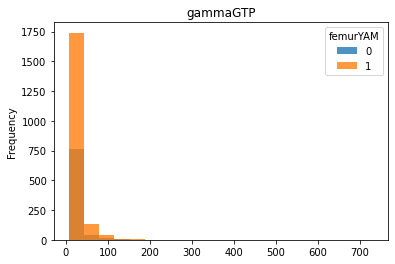

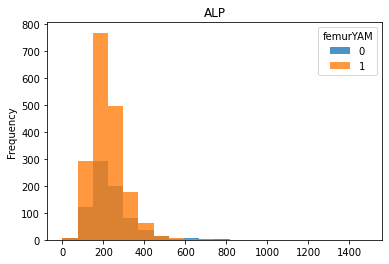

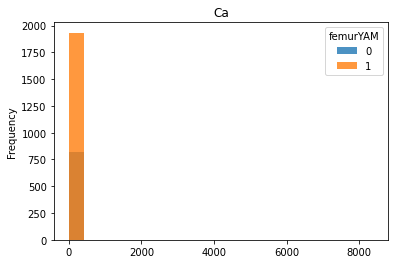

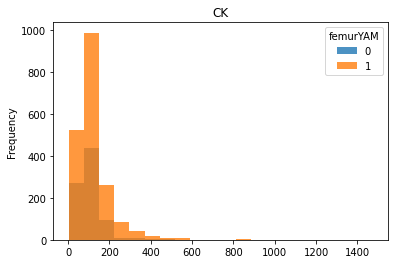

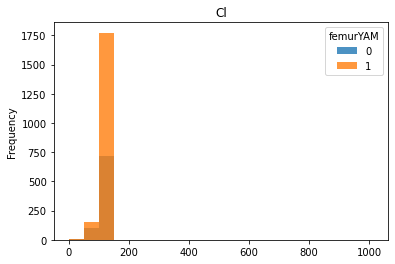

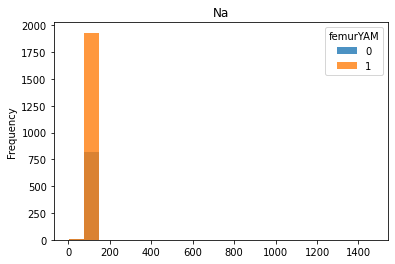

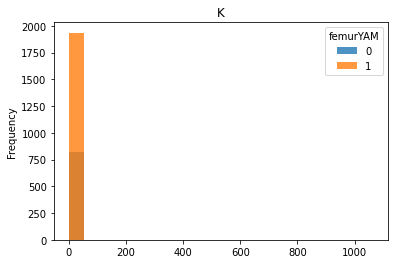

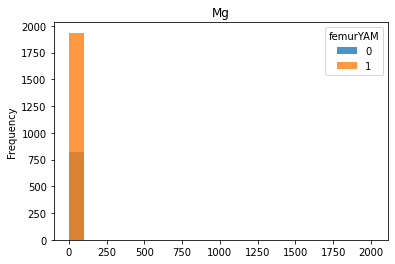

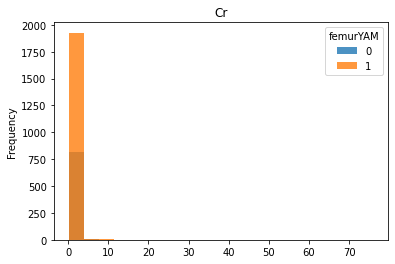

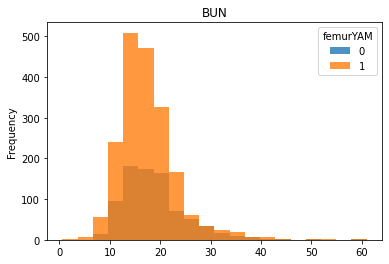

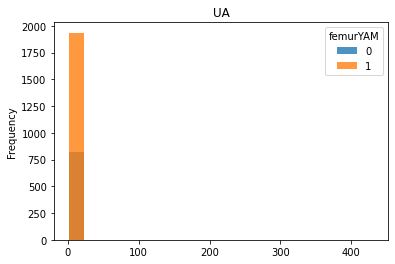

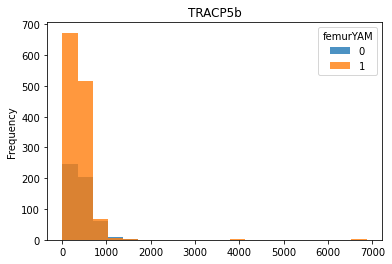

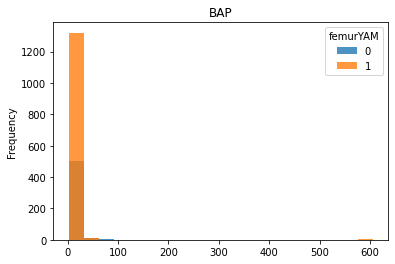

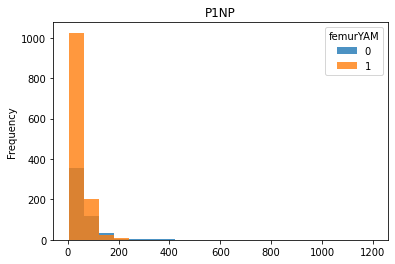

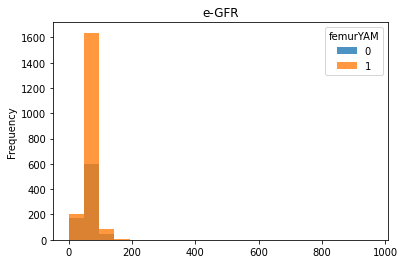

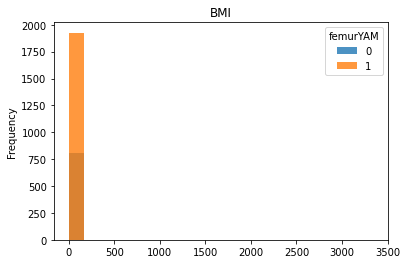

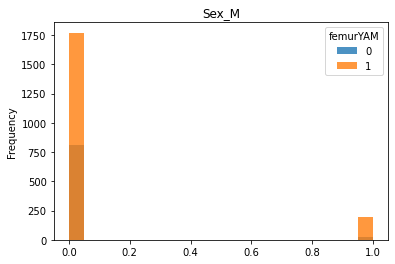

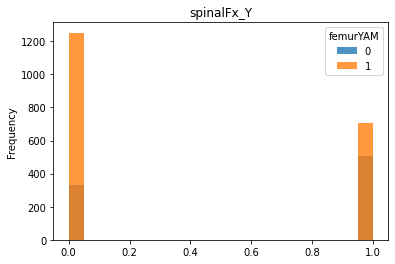

In [ ]:
#関数targethistに引数を渡す　
#pandasのplotをラップしている点を活用してパラメータを指定します。
targethist(df1,target='femurYAM', bins=20, alpha=0.8)

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
Creating an ndarray from ragged nested sequences

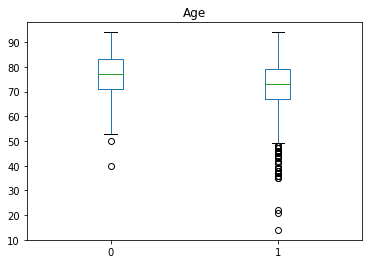

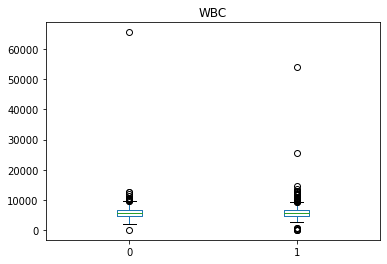

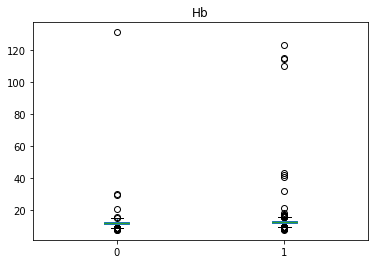

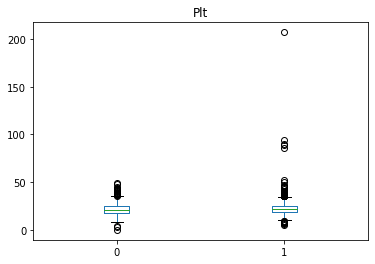

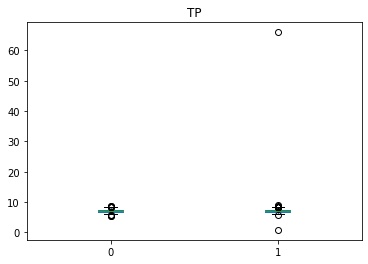

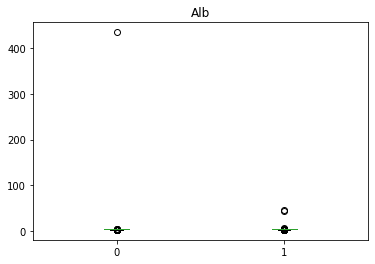

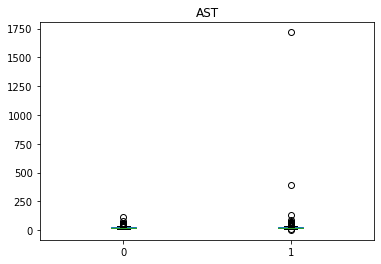

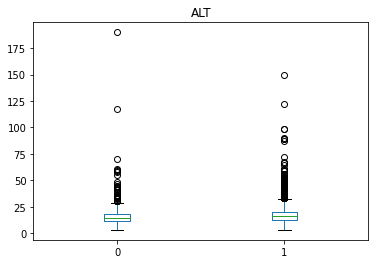

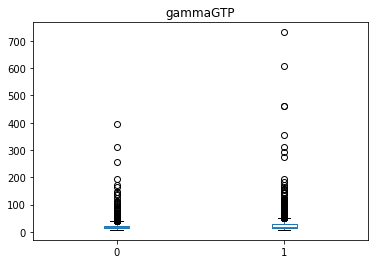

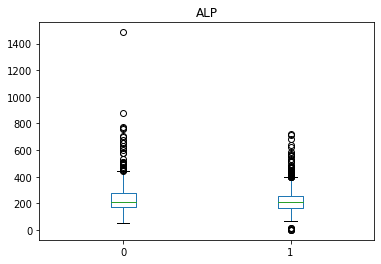

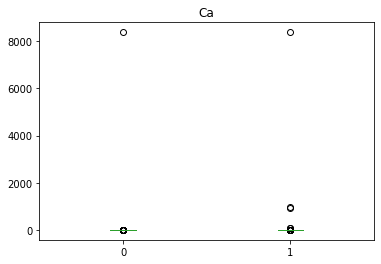

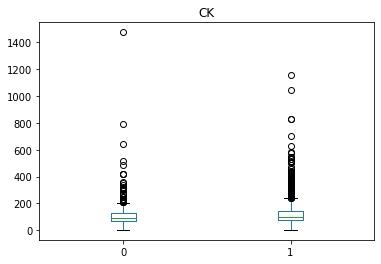

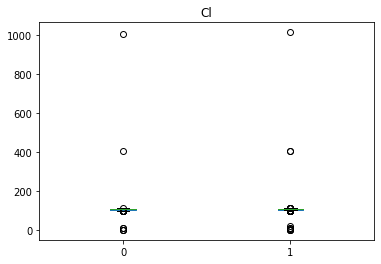

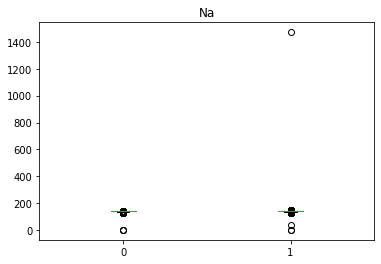

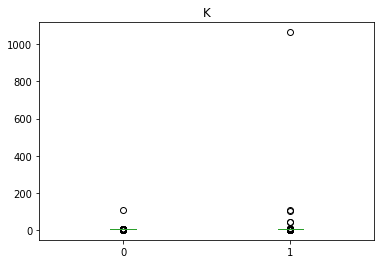

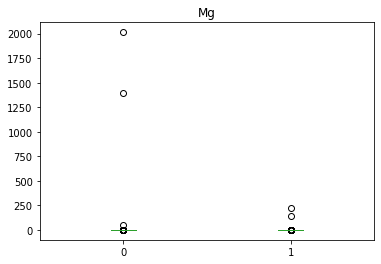

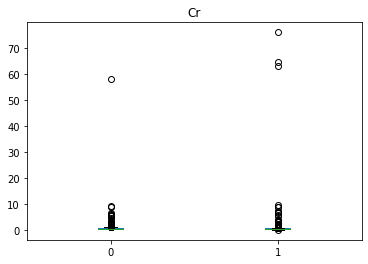

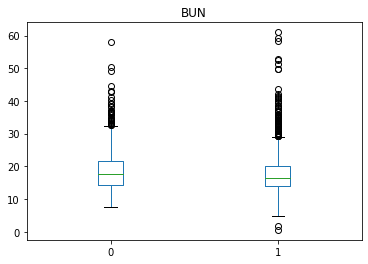

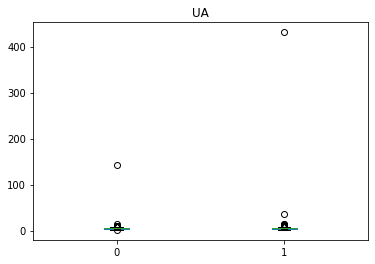

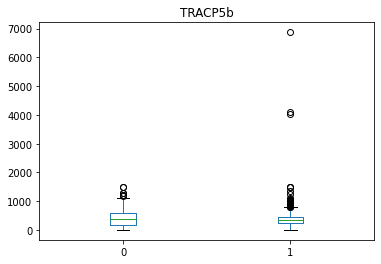

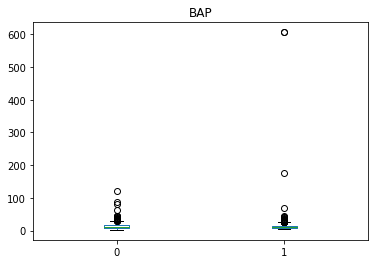

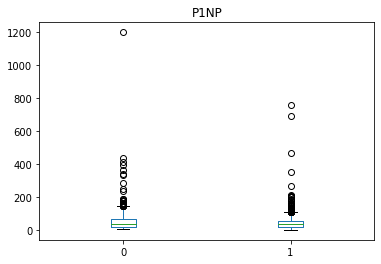

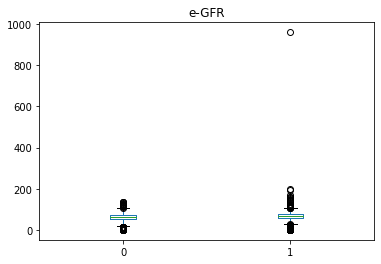

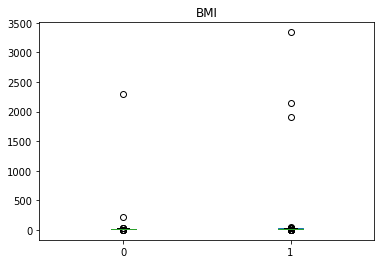

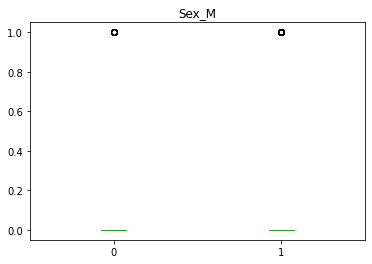

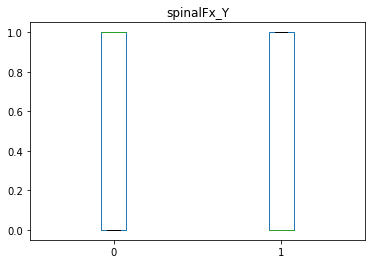

In [ ]:
#Boxplotしてみる
targethist(df1, target="femurYAM", kind='box')

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open

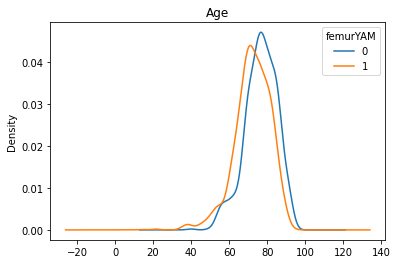

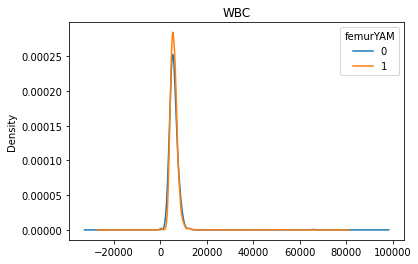

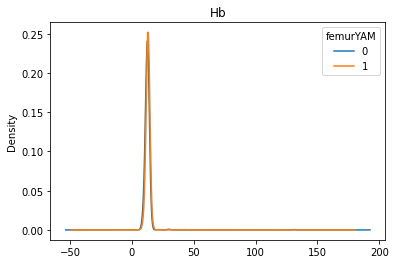

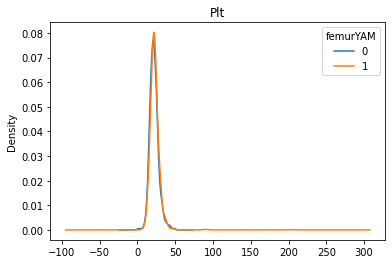

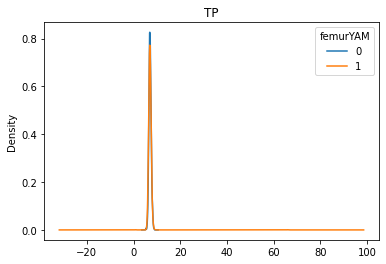

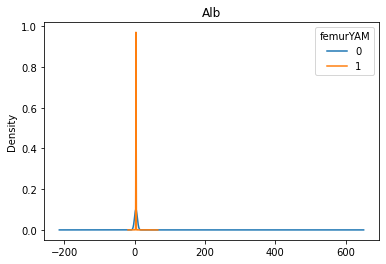

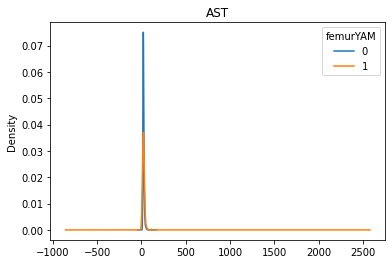

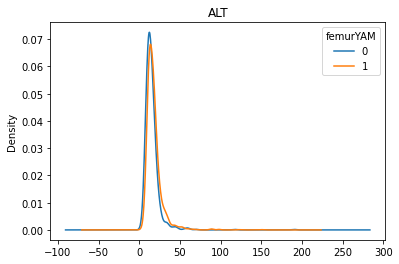

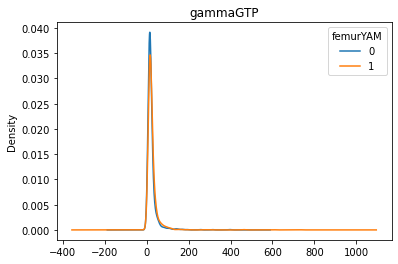

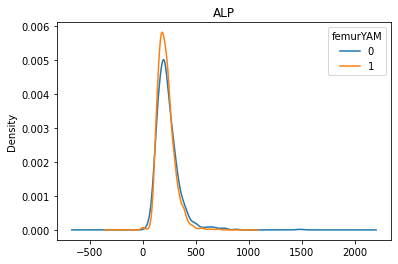

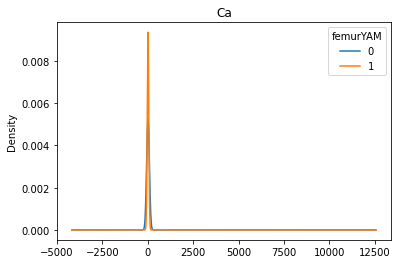

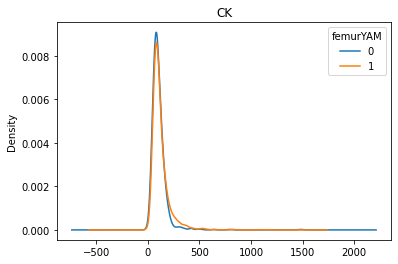

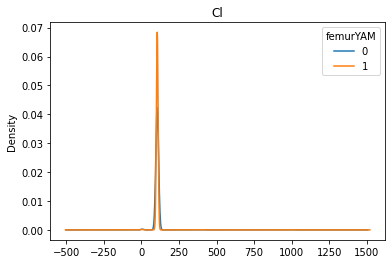

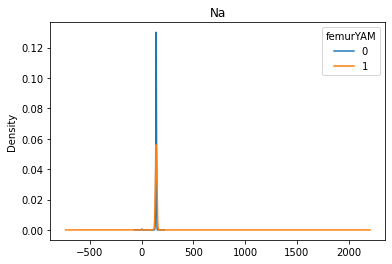

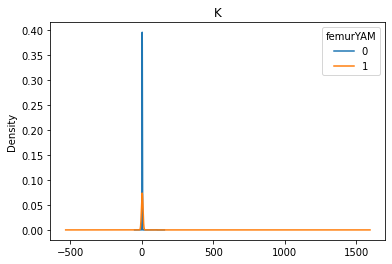

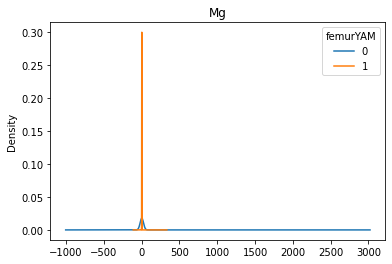

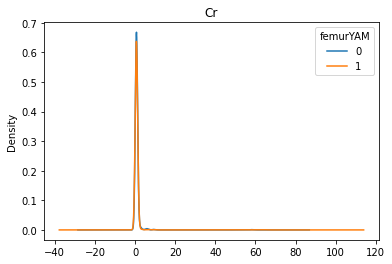

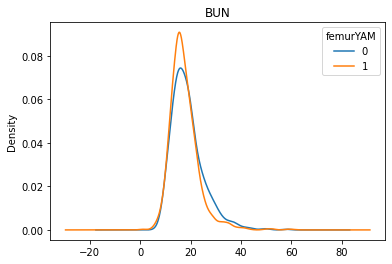

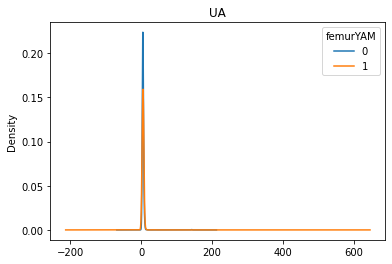

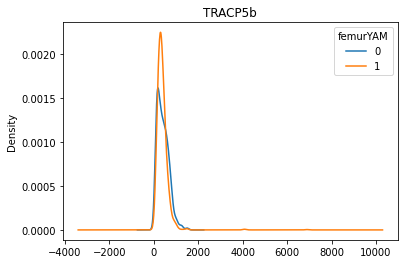

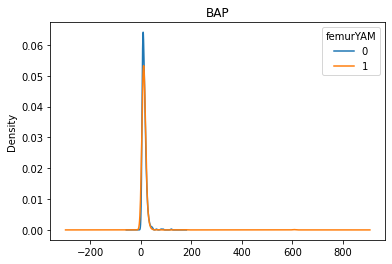

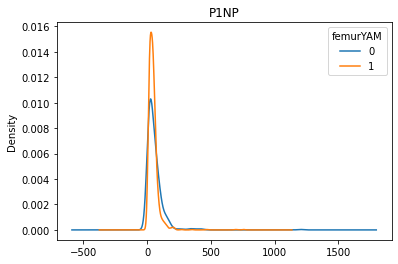

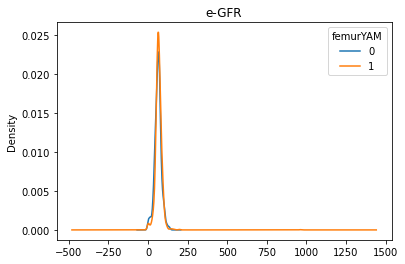

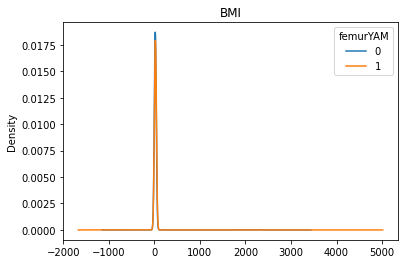

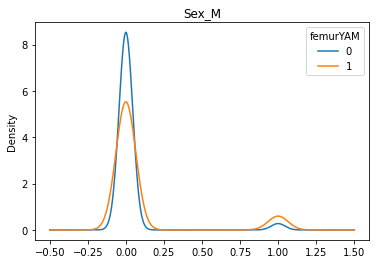

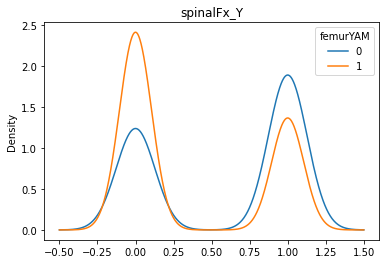

In [ ]:
#カーネル密度推定してみる
targethist(df1, target="femurYAM", kind='kde')

In [ ]:
#femurYAM>=70 (0=No　１＝YES)の有無でグループ分け
grouped=df1.groupby('femurYAM')

In [ ]:
#各グループの平均値を表示 省略されないように5データフレームの50列まで表示するように設定
pd.set_option('display.max_columns', 50)
print(grouped.mean())

                Age          WBC         Hb        Plt        TP       Alb  \
femurYAM                                                                     
0         76.623501  5771.780606  12.510424  22.011394  7.076485  4.536364   
1         72.242689  5831.638545  13.189938  22.850800  7.060583  4.146485   

                AST        ALT   gammaGTP         ALP         Ca          CK  \
femurYAM                                                                       
0         23.253333  15.459394  23.327879  236.361147  19.489059  106.020606   
1         24.011765  18.018060  26.535003  219.288591  14.759561  121.209504   

                  Cl          Na         K        Mg        Cr        BUN  \
femurYAM                                                                    
0         105.624372  140.283867  4.272909  6.272973  0.873697  18.771758   
1         105.543818  141.518209  4.841058  2.254244  0.843354  17.483619   

                UA     TRACP5b        BAP       P1NP     

In [ ]:
#各グル―プの標準偏差を表示
print(grouped.std())

               Age          WBC        Hb       Plt        TP        Alb  \
femurYAM                                                                   
0         8.430051  2615.044210  4.408260  5.804768  0.476924  15.008559   
1         9.563100  1888.207812  4.975996  7.563279  1.412871   1.316271   

                AST        ALT   gammaGTP         ALP          Ca         CK  \
femurYAM                                                                       
0          7.678147  10.165075  26.700414  112.505288  291.327637  79.060078   
1         40.197689   9.899505  34.318550   79.256553  192.648303  85.852700   

                 Cl         Na          K         Mg        Cr       BUN  \
femurYAM                                                                   
0         34.077447   8.589845   3.599981  85.131354  2.108186  6.437281   
1         23.696100  30.707891  24.334559   5.924798  2.699797  5.832394   

                UA     TRACP5b        BAP       P1NP      e-GFR      

In [ ]:
#statsmodelsによる重回帰分析
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

# 何かしらのデータ
df1=df1.fillna(df1.mean())#欠損地があるとerrorになるので、欠損値補完したデータを使用

# get_dummies()カテゴリ変数をone-hot-enchodingで質的データも対応可能
x = pd.get_dummies(df1.drop(['femurYAM',],axis='columns') ) # ←もちろん増減可能 今回は目的変数以外すべて採用
y = df1['femurYAM']#目的変数の列

# 定数項(y切片)を必要とする線形回帰のモデル式ならば必須
X = sm.add_constant(x)

# 最小二乗法によるモデリング
model = sm.OLS(y,X)
result = model.fit()

# 重回帰分析の結果を表示 結果の解釈は　https://tanuhack.com/statsmodels-multiple-lra/#StatsModels
result.summary()

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               femurYAM   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.105
Method:                 Least Squares   F-statistic:                     13.66
Date:                Sun, 19 Sep 2021   Prob (F-statistic):           1.45e-55
Time:                        06:02:49   Log-Likelihood:                -1611.9
No. Observations:                2795   AIC:                             3278.
Df Residuals:                    2768   BIC:                             3438.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0853      0.123      8.814      0.000       0.844       1.327
Age           -0.0066      0.001     -6.556      0.000      -0.009      -0.005
WBC         4.995e-06   3.96e-06      1.260      0.208   -2.78e-06    1.28e-05
Hb             0.0030      0.002      1.765      0.078      -0.000       0.006
Plt            0.0041      0.001      3.416      0.001       0.002       0.007
TP            -0.0024      0.007     -0.346      0.729      -0.016       0.011
Alb           -0.0019      0.001     -1.873      0.061      -0.004     8.8e-05
AST           -0.0002      0.000     -0.651      0.515      -0.001       0.000
ALT            0.0037      0.001      3.782      0.000       0.002       0.006
gammaGTP   -6.012e-05      0.000     -0.207      0.836      -0.001       0.001
ALP           -0.0003      0.000     -3.241      0.001      -0.001      -0.000
Ca         -6.867e-07   3.64e-05     -0.019      0.985   -7.21e-05    7.07e-05
CK             0.0004      0.000      3.993      0.000       0.000       0.001
Cl         -7.808e-05      0.000     -0.257      0.797      -0.001       0.001
Na             0.0003      0.000      0.905      0.366      -0.000       0.001
K              0.0003      0.000      0.706      0.480      -0.001       0.001
Mg            -0.0003      0.000     -1.944      0.052      -0.001    2.88e-06
Cr             0.0003      0.003      0.083      0.933      -0.006       0.007
BUN           -0.0016      0.002     -1.036      0.300      -0.005       0.001
UA             0.0009      0.001      0.955      0.340      -0.001       0.003
TRACP5b     3.409e-06   3.95e-05      0.086      0.931   -7.41e-05    8.09e-05
BAP            0.0002      0.000      0.463      0.643      -0.001       0.001
P1NP          -0.0003      0.000     -1.192      0.233      -0.001       0.000
e-GFR         -0.0002      0.000     -0.436      0.663      -0.001       0.001
BMI         2.559e-05    8.8e-05      0.291      0.771      -0.000       0.000
Sex_M          0.2127      0.031      6.801      0.000       0.151       0.274
spinalFx_Y    -0.1584      0.018     -8.953      0.000      -0.193      -0.124
==============================================================================
Omnibus:                      676.035   Durbin-Watson:                   0.177
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              366.392
Skew:                          -0.751   Prob(JB):                     2.75e-80
Kurtosis:                       2.058   Cond. No.                     9.34e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.34e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
""

In [ ]:
#分類するクラスを確認  'DAS<2.3'=0が寛解未達成　１が寛解達成
df1['femurYAM'].value_counts()

1    1961
0     834
Name: femurYAM, dtype: int64

In [ ]:
#データセットの分割　正解クラス　説明変数の指定
#訓練データの不要な列を df.drop([],axis='columns')で指定
train_x=df1.drop(['femurYAM'],axis='columns') 
train_y=df1['femurYAM']
(train_x,test_x,train_y,test_y)=train_test_split(train_x,train_y,test_size=0.1,random_state=0)

In [ ]:
#データセットの形確認
print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

(2515, 26)
(280, 26)
(2515,)
(280,)


In [ ]:
#評価用関数のインポートおよび定義
from sklearn.metrics import recall_score#recall score用の関数インポート
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

In [ ]:
#特異度の計算には、自分で scorer 作る
# さらに、確実のため、感度も改めて定義しておく。こちらを cross validation でも用いる。

#感度
def sensitivity1(test_y, pred_y):
    cm = confusion_matrix(test_y,pred_y, labels=[1, 0])
    return cm[0, 0]/ (cm[0,0]+cm[0,1])

#特異度
def specificity1(test_y, pred_y):
    cm = confusion_matrix(test_y, pred_y, labels=[1, 0])
    return cm[1, 1]/ (cm[1,0]+cm[1,1])

In [ ]:
#LightGBM scikit learn APIによる訓練 confusion matrix関数を使うにはsk-learn APIが必要

model_lgb = lgb.LGBMClassifier(objective='binary',
                        metric='auc',
                        n_estimators=1000,
                        early_stopping_rounds=100)
model_lgb.fit(train_x,train_y,#scilit learn APIではfitで訓練データを渡す original APIではtrain 
        eval_set=[(test_x, test_y)],
        verbose=50)

Training until validation scores don't improve for 100 rounds.


Found `early_stopping_rounds` in params. Will use it instead of argument


[50]	valid_0's auc: 0.883665
[100]	valid_0's auc: 0.894818
[150]	valid_0's auc: 0.902082
[200]	valid_0's auc: 0.904999
[250]	valid_0's auc: 0.907001
[300]	valid_0's auc: 0.909918
[350]	valid_0's auc: 0.906772
Early stopping, best iteration is:
[297]	valid_0's auc: 0.910776


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               early_stopping_rounds=100, importance_type='split',
               learning_rate=0.1, max_depth=-1, metric='auc',
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=1000, n_jobs=-1, num_leaves=31, objective='binary',
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

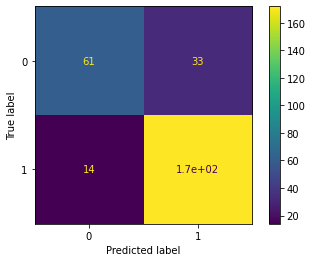

In [ ]:
#混合行列の可視化
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
plot_confusion_matrix(model_lgb,test_x,test_y)

In [ ]:
#２値分類の評価指標の計算

from sklearn.metrics import accuracy_score #正解率

pred_y=model_lgb.predict(test_x)
acc=accuracy_score(test_y,pred_y)
recall=recall_score(test_y,pred_y)
precision=precision_score(test_y,pred_y)
f_measure=f1_score(test_y,pred_y)
print('Accuracy:',acc)
print('Recall:',recall)
print('Precision:',precision)
print('F-measure:{}'.format(f_measure))
sensitivity=sensitivity1(test_y,pred_y)
print('Sensitivity:{}'.format(sensitivity))
specificity=specificity1(test_y,pred_y)
print('Specificity:{}'.format(specificity))
conf_matrix=confusion_matrix(test_y,pred_y)
tn,fp,fn,tp=conf_matrix.ravel()
print('tn,fp,fn,tp=',tn,fp,fn,tp)

Accuracy: 0.8321428571428572
Recall: 0.9247311827956989
Precision: 0.8390243902439024
F-measure:0.8797953964194373
Sensitivity:0.9247311827956989
Specificity:0.648936170212766
tn,fp,fn,tp= 61 33 14 172


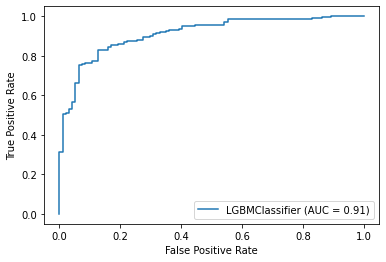

In [ ]:
from sklearn import metrics
lgb_disp=metrics.plot_roc_curve(model_lgb,test_x,test_y)  # LGBMClassigier modelのROC曲線
plt.show()       

In [ ]:
#LightGBMの学習 originalAPIを使ってみる

lgb_train=lgb.Dataset(train_x, label=train_y, categorical_feature='auto')
lgb_eval=lgb.Dataset(test_x, label= test_y, categorical_feature='auto')

# パラメータの設定
#※２値分類の場合 'objective': 'binary', 'metric': 'binary_error' #評価指標：正答率
parms = {
    'task': 'train', #トレーニング用
    'boosting': 'gbdt', #勾配ブースティング決定木
    'objective': 'binary', #目的：多値分類
    'metric': 'auc', #評価指標:auc
    'num_iterations': 1000, #1000回学習
    'verbose': 50 ,#学習情報？　1がデフォルト
    'max_depth':6
}

# モデルの学習
lgb_model = lgb.train(parms,
                 #訓練データ
                 train_set=lgb_train,
                 # 評価データ
                 valid_sets=lgb_eval,
                 early_stopping_rounds=100)

Found `num_iterations` in params. Will use it instead of argument


[1]	valid_0's auc: 0.782086
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.792467
[3]	valid_0's auc: 0.804507
[4]	valid_0's auc: 0.821036
[5]	valid_0's auc: 0.818949
[6]	valid_0's auc: 0.82953
[7]	valid_0's auc: 0.828643
[8]	valid_0's auc: 0.824554
[9]	valid_0's auc: 0.824554
[10]	valid_0's auc: 0.829387
[11]	valid_0's auc: 0.836736
[12]	valid_0's auc: 0.834963
[13]	valid_0's auc: 0.837938
[14]	valid_0's auc: 0.836022
[15]	valid_0's auc: 0.835335
[16]	valid_0's auc: 0.836822
[17]	valid_0's auc: 0.838252
[18]	valid_0's auc: 0.837852
[19]	valid_0's auc: 0.838424
[20]	valid_0's auc: 0.838881
[21]	valid_0's auc: 0.840597
[22]	valid_0's auc: 0.842485
[23]	valid_0's auc: 0.844143
[24]	valid_0's auc: 0.845802
[25]	valid_0's auc: 0.846259
[26]	valid_0's auc: 0.847117
[27]	valid_0's auc: 0.846431
[28]	valid_0's auc: 0.847804
[29]	valid_0's auc: 0.848547
[30]	valid_0's auc: 0.849234
[31]	valid_0's auc: 0.852837
[32]	valid_0's auc: 0.854724
[33]	valid_0's auc:

Accuracy: 0.8321428571428572
Recall: 0.9247311827956989
Precision: 0.8390243902439024
F-measure:0.8797953964194373
Sensitivity:0.9247311827956989
Specificity:0.648936170212766
tn,fp,fn,tp= 61 33 14 172


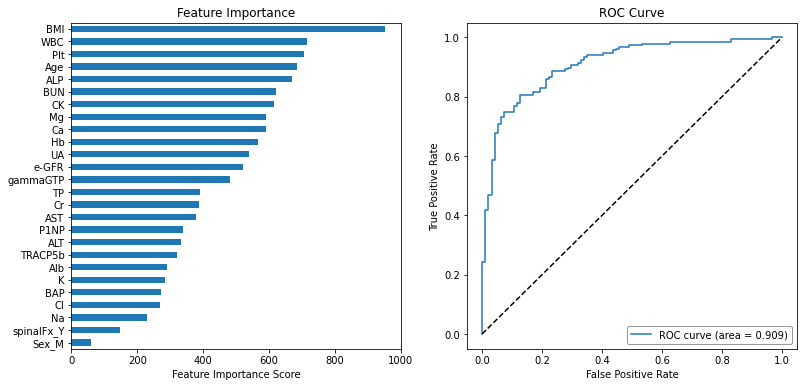

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import classification_report
# テストデータによる推論
y_pred = lgb_model.predict(test_x, num_iteration=lgb_model.best_iteration)

# 評価指標の計算
fpr, tpr, thresholds = roc_curve(test_y, y_pred)
roc_auc = auc(fpr, tpr)

# 重要変数とROC-Curveの可視化
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13,6))
feat_imp = pd.Series(lgb_model.feature_importance(), index=test_x.columns).sort_values(ascending=False)
feat_imp = feat_imp.head(30)
feat_imp = feat_imp.sort_values(ascending=True)
feat_imp.plot(kind='barh', title='Feature Importance', ax=axes[0], color=sns.color_palette()[0])
axes[0].set_xlabel('Feature Importance Score')
axes[1].plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
axes[1].plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
legend = axes[1].legend(frameon=True, loc='lower right', fontsize = 'medium') # 凡例
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('gray')
acc=accuracy_score(test_y,pred_y)
recall=recall_score(test_y,pred_y)
precision=precision_score(test_y,pred_y)
f_measure=f1_score(test_y,pred_y)
print('Accuracy:',acc)
print('Recall:',recall)
print('Precision:',precision)
print('F-measure:{}'.format(f_measure))
sensitivity=sensitivity1(test_y,pred_y)
print('Sensitivity:{}'.format(sensitivity))
specificity=specificity1(test_y,pred_y)
print('Specificity:{}'.format(specificity))
conf_matrix=confusion_matrix(test_y,pred_y)
tn,fp,fn,tp=conf_matrix.ravel()
print('tn,fp,fn,tp=',tn,fp,fn,tp)

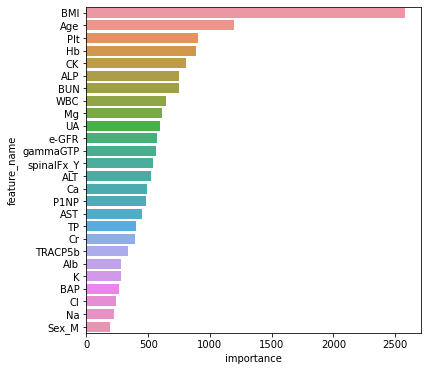

In [ ]:
#feature importanceの可視化 その2
feature_importance = pd.DataFrame({
    'feature_name': lgb_model.feature_name(),
    'importance': lgb_model.feature_importance(importance_type='gain'),
})
feature_importance = feature_importance.sort_values('importance', ascending = False)

plt.figure(figsize= (6,6))
sns.barplot(data = feature_importance, x ='importance', y='feature_name')
plt.savefig('classification_feature_importance.png')

Found `early_stopping_round` in params. Will use it instead of argument


[1]	valid_0's auc: 0.747426
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.743022
[3]	valid_0's auc: 0.771477
[4]	valid_0's auc: 0.785146
[5]	valid_0's auc: 0.788492
[6]	valid_0's auc: 0.796042
[7]	valid_0's auc: 0.786862
[8]	valid_0's auc: 0.799302
[9]	valid_0's auc: 0.810169
[10]	valid_0's auc: 0.813344
[11]	valid_0's auc: 0.808825
[12]	valid_0's auc: 0.807853
[13]	valid_0's auc: 0.804593
[14]	valid_0's auc: 0.807567
[15]	valid_0's auc: 0.808625
[16]	valid_0's auc: 0.808024
[17]	valid_0's auc: 0.807796
[18]	valid_0's auc: 0.808196
[19]	valid_0's auc: 0.811285
[20]	valid_0's auc: 0.808596
[21]	valid_0's auc: 0.808539
[22]	valid_0's auc: 0.808711
[23]	valid_0's auc: 0.807281
[24]	valid_0's auc: 0.808482
[25]	valid_0's auc: 0.810084
[26]	valid_0's auc: 0.809168
[27]	valid_0's auc: 0.810941
[28]	valid_0's auc: 0.811399
[29]	valid_0's auc: 0.810827
[30]	valid_0's auc: 0.81117
[31]	valid_0's auc: 0.813744
[32]	valid_0's auc: 0.814316
[33]	valid_0's auc:

100%|===================| 2504/2515 [02:48<00:00]       

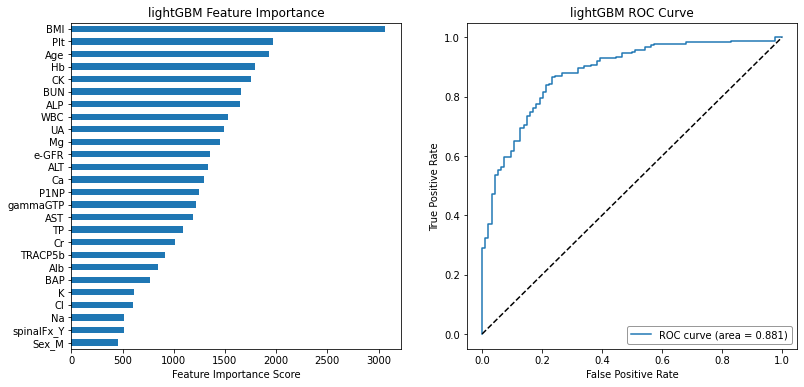

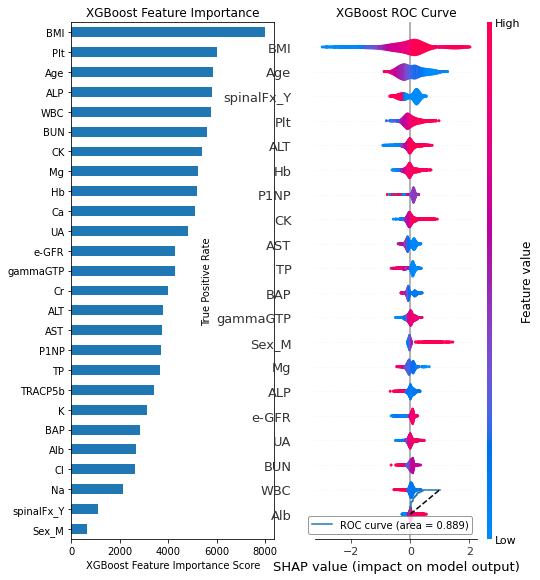

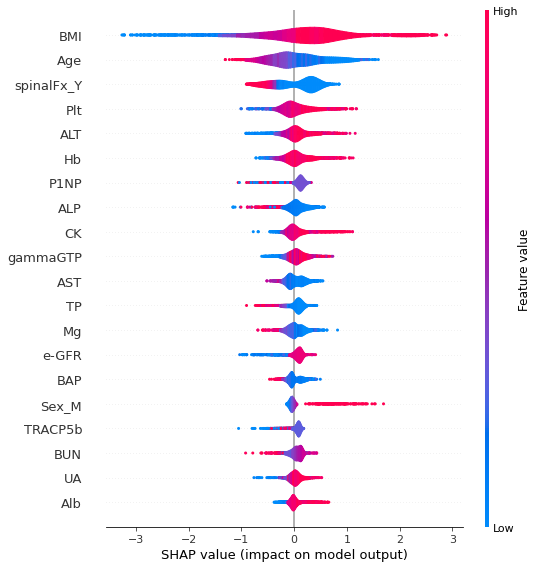

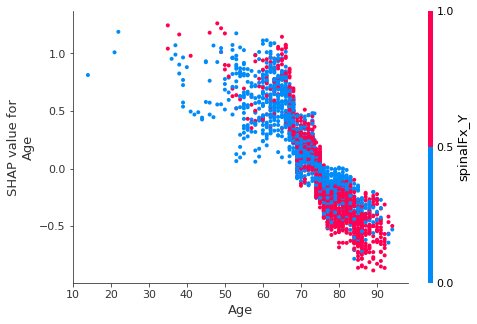

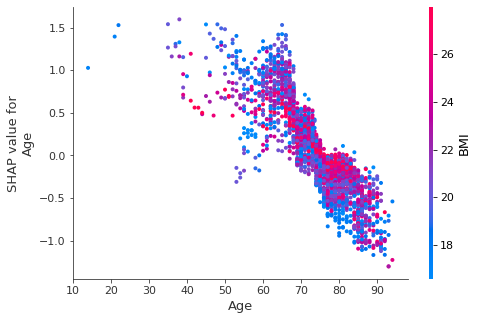

In [ ]:
#SHAPスコアの練習　xgboostとlightGBMの比較　
#参考サイト　https://takaherox.hatenablog.com/entry/2020/07/06/234337
import numpy as np
import pandas as pd
import xgboost as xgb
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import classification_report

# 固定パラメータの指定
SEED = 42
TEST_SIZE = 0.2
target = "class"
predictors = [i for i in df.columns if i not in target]

# Lightgのハイパーパラメータ
lgb_params = {
    'task': 'train',
    'max_depth': 10,
    'metric': 'auc',
    'objective': 'binary',
    'boosting': 'gbdt',
    'learning_rate': 0.005,
    'seed': SEED,
    'num_threads': 8,
    'early_stopping_round': 100,
    'subsample': .8,
    'min_gain_to_split': .1, 
    'lambda_l1': 1,
    'lambda_l2': 0,
    'min_child_weight': .8,
    'feature_fraction': .8,
    'num_leaves': 31,
    'verbosity': -1,
}

# モデルの学習
lgb_train = lgb.Dataset(train_x,train_y)
lgb_eval = lgb.Dataset(test_x, test_y)
lgb_model = lgb.train(
    params=lgb_params,
    train_set=lgb_train,
   num_boost_round=5000,
    valid_sets=lgb_eval
)

# テストデータによる推論
y_pred = lgb_model.predict(test_x, num_iteration=lgb_model.best_iteration)

# 評価指標の計算
fpr, tpr, thresholds = roc_curve(test_y, y_pred)
roc_auc = auc(fpr, tpr)

# 重要変数とROC-Curveの可視化
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13,6))
feat_imp = pd.Series(lgb_model.feature_importance(), index=test_x.columns).sort_values(ascending=False)
feat_imp = feat_imp.head(30)
feat_imp = feat_imp.sort_values(ascending=True)
feat_imp.plot(kind='barh', title='lightGBM Feature Importance', ax=axes[0], color=sns.color_palette()[0])
axes[0].set_xlabel('Feature Importance Score')
axes[1].plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
axes[1].plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('lightGBM ROC Curve')
legend = axes[1].legend(frameon=True, loc='lower right', fontsize = 'medium') # 凡例
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('gray')
acc=accuracy_score(test_y,pred_y)
recall=recall_score(test_y,pred_y)
precision=precision_score(test_y,pred_y)
f_measure=f1_score(test_y,pred_y)
print('Accuracy:',acc)
print('Recall:',recall)
print('Precision:',precision)
print('F-measure:{}'.format(f_measure))
sensitivity=sensitivity1(test_y,pred_y)
print('Sensitivity:{}'.format(sensitivity))
specificity=specificity1(test_y,pred_y)
print('Specificity:{}'.format(specificity))
conf_matrix=confusion_matrix(test_y,pred_y)
tn,fp,fn,tp=conf_matrix.ravel()
print('tn,fp,fn,tp=',tn,fp,fn,tp)

# xgboostのハイパーパラメータ
xgb_params = {
    "booster": "gbtree",
    "max_depth": 10,
    "objective": "binary:logistic",
    'eval_metric': 'auc',
    "eta": 0.005,
    "seed": 42,
    "nthread": 8,
    "subsample": 0.8,
    "gamma": 0,
    "alpha": .1,
    "lambda": 0,
    "min_child_weight": .8,
    "colsample_bytree": .8,
    "max_leaves": 31
}

# モデルの学習
xgb_train = xgb.DMatrix(train_x,train_y)
xgb_test = xgb.DMatrix(test_x, test_y)
evals_result = {}
xgb_model = xgb.train(
    xgb_params,
    xgb_train,
    num_boost_round=5000,  
    early_stopping_rounds=500,
    evals = [(xgb_test, 'eval'), (xgb_train, 'train')],
    evals_result=evals_result
)

# テストデータによる推論
y_pred_xgb = xgb_model.predict(xgb_test)

# 評価指標の計算
fpr, tpr, thresholds = roc_curve(test_y, y_pred_xgb)
roc_auc = auc(fpr, tpr)

# 重要変数とROC-Curveの可視化
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13,6))
feat_imp = pd.Series(xgb_model.get_fscore()).sort_values(ascending=False)
feat_imp = feat_imp.head(30)
feat_imp = feat_imp.sort_values(ascending=True)
feat_imp.plot(kind='barh', title='XGBoost Feature Importance', ax=axes[0], color=sns.color_palette()[0])
axes[0].set_xlabel('XGBoost Feature Importance Score')
axes[1].plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
axes[1].plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost ROC Curve')
legend = axes[1].legend(frameon=True, loc='lower right', fontsize = 'medium') # 凡例
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('gray')
acc=accuracy_score(test_y,pred_y)
recall=recall_score(test_y,pred_y)
precision=precision_score(test_y,pred_y)
f_measure=f1_score(test_y,pred_y)
print('Accuracy:',acc)
print('Recall:',recall)
print('Precision:',precision)
print('F-measure:{}'.format(f_measure))
sensitivity=sensitivity1(test_y,pred_y)
print('Sensitivity:{}'.format(sensitivity))
specificity=specificity1(test_y,pred_y)
print('Specificity:{}'.format(specificity))
conf_matrix=confusion_matrix(test_y,pred_y)
tn,fp,fn,tp=conf_matrix.ravel()
print('tn,fp,fn,tp=',tn,fp,fn,tp)

!pip install shap

# LightGBMのSHAP Valueの計算
import shap
lgb_explainer = shap.TreeExplainer(lgb_model, train_x)
lgb_shap_values = lgb_explainer.shap_values(train_x)

# XgboostのSHAP Valueの計算
xgb_explainer = shap.TreeExplainer(xgb_model)
xgb_shap_values = xgb_explainer.shap_values(train_x)



# jupyter notebookにコードを表示させるためにjsをロード
shap.initjs()
# LightGBMでのViolin Plotの可視化
shap.summary_plot(lgb_shap_values, train_x, plot_type="violin")#ploty type 'dot' or 'violin'

# XgboostでのViolin Plotの可視化
shap.summary_plot(xgb_shap_values,train_x,plot_type='violin')

#RandomForestでのViolinPlotの可視化
#shap.summary_plot(rf_shap_values,train_x)#ここだけviokinやdotにするとエラーが出る

# LightGBMでのPartial Dependence Plotの可視化
shap.dependence_plot("rank(1)", lgb_shap_values, train_x)

# XgboostでのPartial Dependence Plotの可視化
shap.dependence_plot("rank(1)", xgb_shap_values, train_x)